In [ ]:
"""
Name: Ritesh patil
PRN: 1262240727

Problem statement:
COVID-19 Chest X-ray Classification: Classify chest X-ray images to detect COVID-19 or pneumonia.

"""

In [21]:
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

True


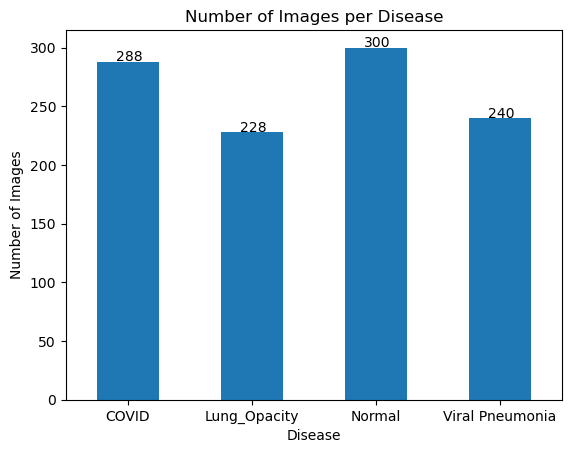

Training set size = 844, Validation set size = 106, Test set size = 106


In [22]:
# Define the directory containing the COVID-19 radiography images
data_dir ="C:\\Users\\Ritesh\\Documents\\Covid\\Dataset"
print(os.path.exists(data_dir))  # Should print True if the path is correct
# Initialize two empty lists to store the image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse through all four folders of the dataset directory and map the files to their class names
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)

    if pathlib.Path(folder_path).suffix != '':
        continue

    if os.path.isdir(folder_path):
        file_list = os.listdir(folder_path)

        for file in file_list:
            file_path = os.path.join(folder_path, file)

            if os.path.isdir(file_path):
                if pathlib.Path(folder_path).suffix == '':
                    # Ignore the mask folders since they are not used
                    if pathlib.Path(file_path).parts[-1] in ['masks', 'Masks', 'MASKS']:
                        continue
                    else:
                        original_file_list = os.listdir(file_path)

                        for f in original_file_list:
                            img_path = os.path.join(file_path, f)
                            image_paths.append(img_path)
                            labels.append(folder)
                else:
                    image_paths.append(file_path)
                    labels.append(folder)
# Store the image file names and their corresponding class names in a Pandas DataFrame
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Visualize the number of images per class
label_counts = data_frame.groupby('labels')['image_paths'].count()
ax = label_counts.plot(kind='bar')

plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')
plt.xticks(rotation=0)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(i.get_height()), fontsize=10)

plt.show()

# Split the data into training, validation, and test sets at a ratio of 80-10-10
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

print(f'Training set size = {len(train_df)}, Validation set size = {len(valid_df)}, Test set size = {len(test_df)}')

In [23]:


# Determine the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length that are less than or equal to 80
factors = []
for n in range(1, test_length + 1):
    if test_length % n == 0 and test_length // n <= 80:
        factors.append(n)

# Select the largest factor as the test batch size
test_batch_size = max(sorted(factors, reverse=True))

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged
def identity(img):
    return img

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(preprocessing_function=identity, horizontal_flip=True)
test_augmentor = ImageDataGenerator(preprocessing_function=identity)

train_gen = train_augmentor.flow_from_dataframe(
    train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = test_augmentor.flow_from_dataframe(
    valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = test_augmentor.flow_from_dataframe(
    test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 844 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.


In [24]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)    

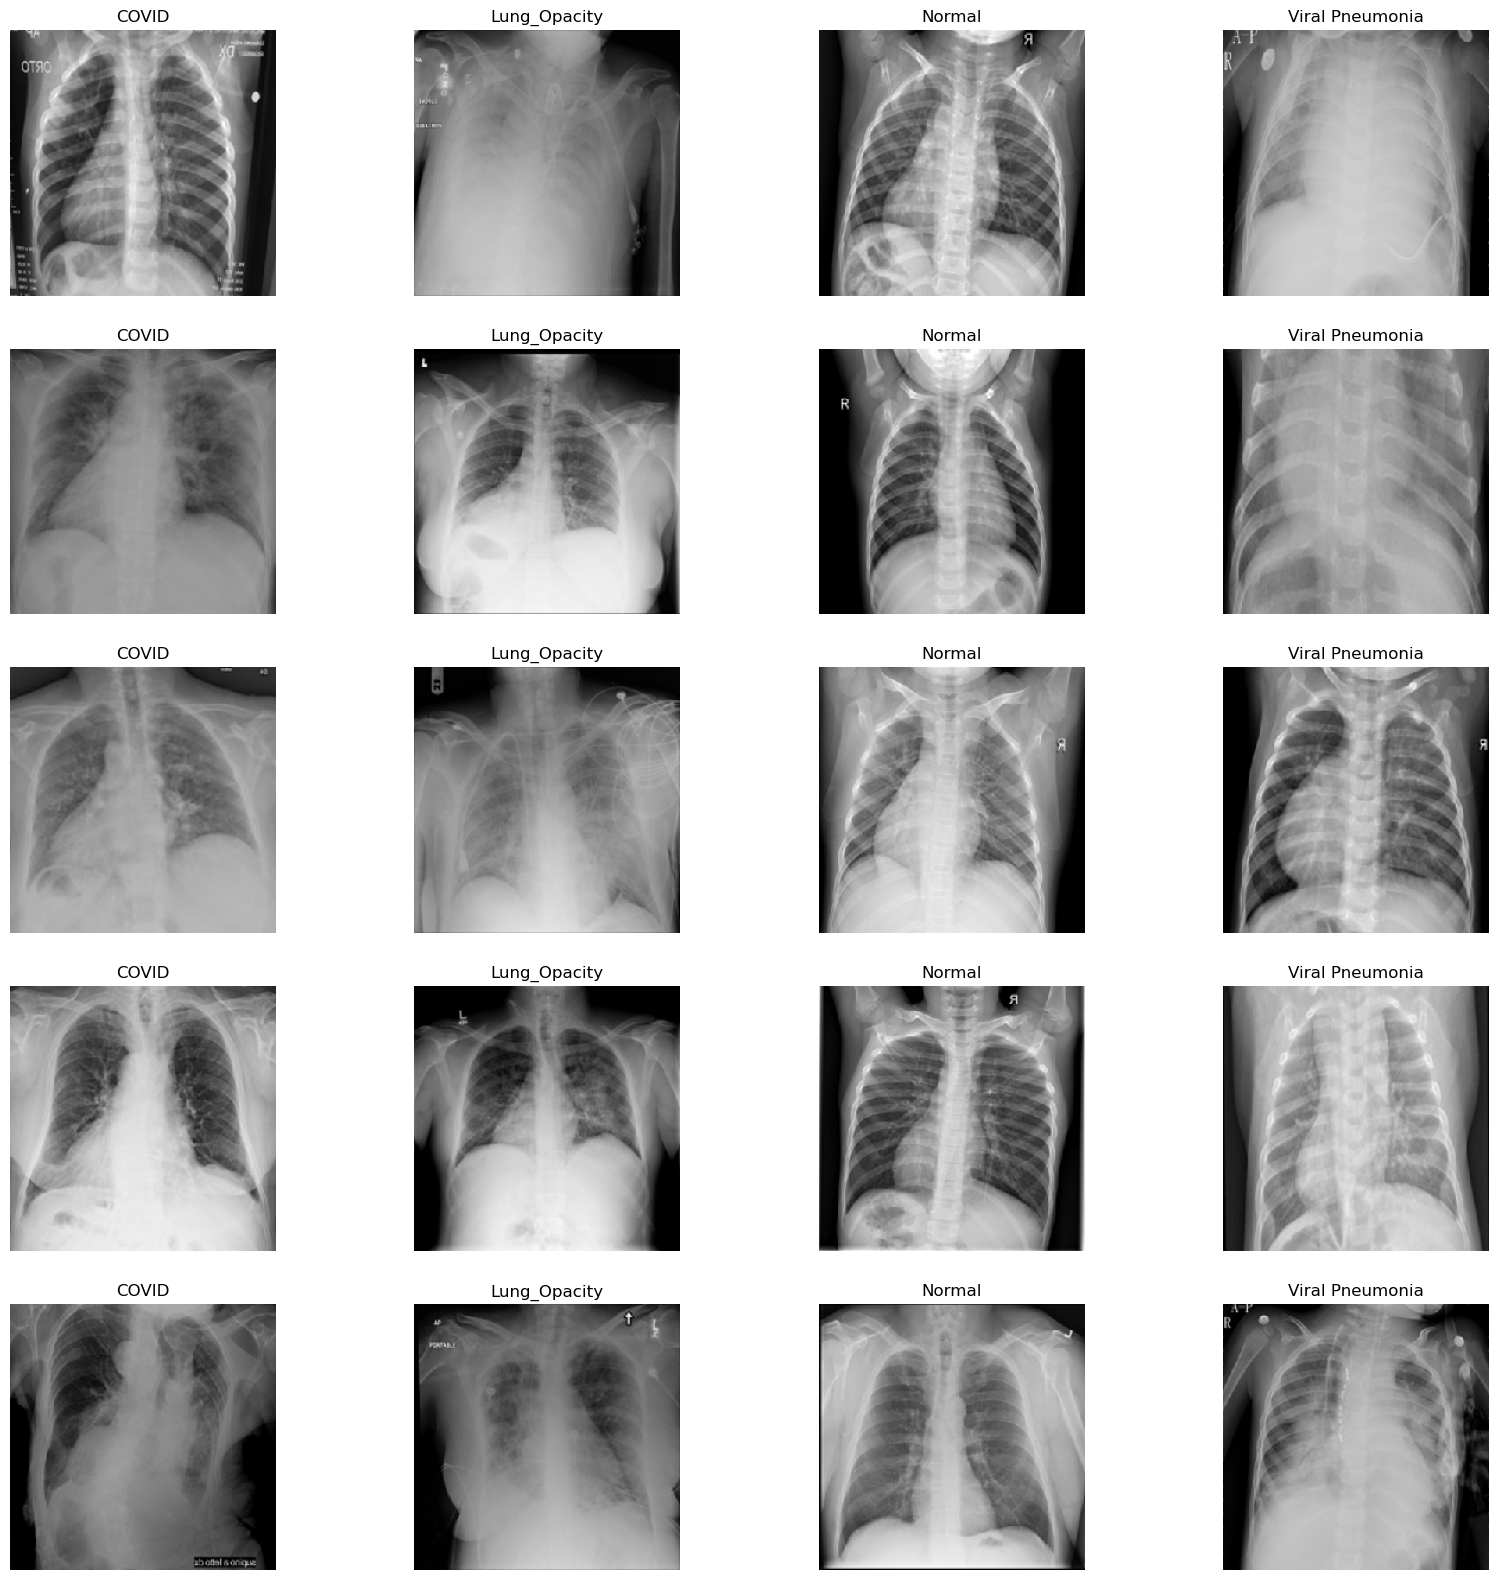

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()


In [26]:
# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)


# Define the LeNet model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 54, 54, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(
    train_gen,
    epochs=10,
    callbacks = early_stop,
    validation_data=valid_gen,)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 559ms/step - accuracy: 0.4676 - loss: 343.9109 - val_accuracy: 0.6792 - val_loss: 0.8874
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.7962 - loss: 0.5696 - val_accuracy: 0.6321 - val_loss: 1.0384
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.8736 - loss: 0.3956 - val_accuracy: 0.6321 - val_loss: 1.0675
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.7854 - loss: 1.5291 - val_accuracy: 0.6321 - val_loss: 1.2589
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 525ms/step - accuracy: 0.8389 - loss: 0.5083 - val_accuracy: 0.6038 - val_loss: 1.3325
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 547ms/step - accuracy: 0.9204 - loss: 0.2791 - val_accuracy: 0.6321 - val_loss: 1.6332


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Precision: 0.73
Recall: 0.73
F1-score: 0.73
Optimizer: Adam
Regularizer: None
Learning Rate: 1e-05
Epochs: 6


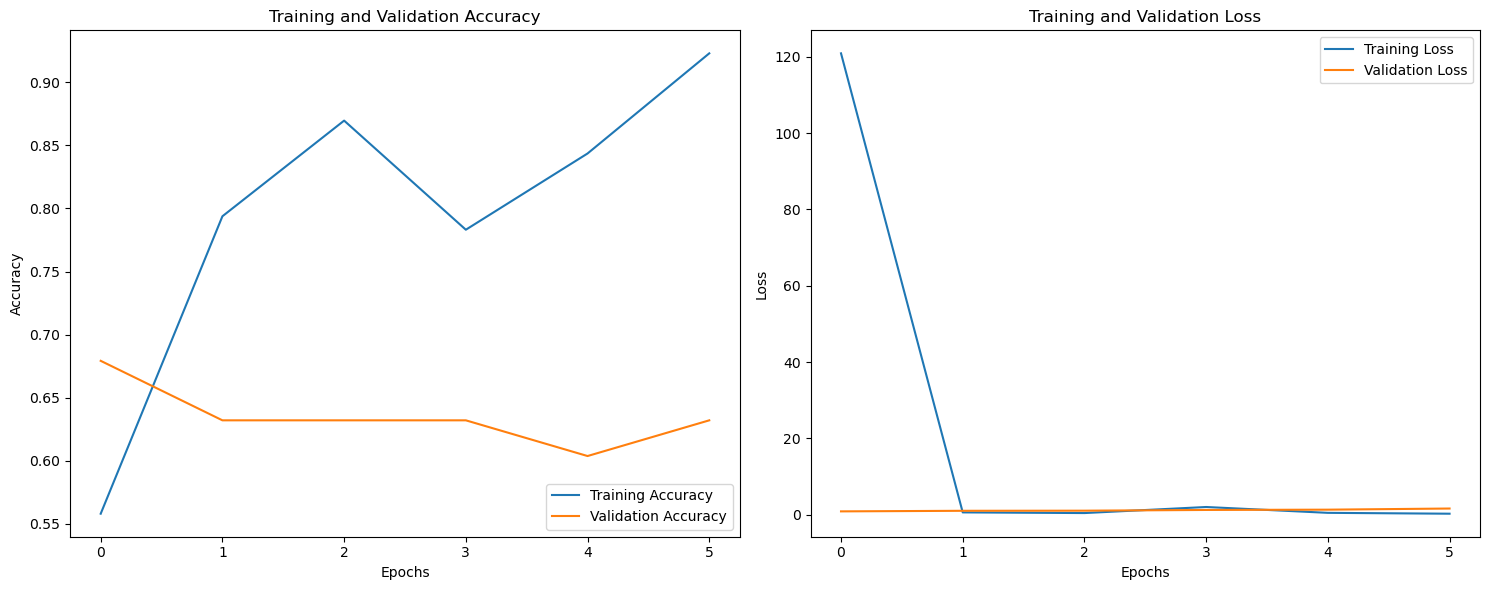

In [32]:
# Step 1: Evaluate the model
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

# Step 2: Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys(), output_dict=True)

# Step 3: Extract metrics
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Step 4: Store hyperparameters
optimizer = 'Adam'  # Use the name of the optimizer you used
regularizer = None  # Specify if you used any regularization techniques
learning_rate = 1e-5  # Use the learning rate you set
epochs = len(history.history['accuracy'])

# Step 5: Print metrics and hyperparameters
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")
print(f"Optimizer: {optimizer}")
print(f"Regularizer: {regularizer}")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")

# Step 6: Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(15, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [33]:
# Step 1: Make predictions on the test set
predictions = model.predict(test_gen)

# Step 2: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Get true labels from the test generator
true_classes = test_gen.classes

# Step 4: Generate a classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())
print("Classification Report:\n", class_report)

# Step 5: Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.70      0.66      0.68        29
   Lung_Opacity       0.60      0.65      0.62        23
         Normal       0.71      0.73      0.72        30
Viral Pneumonia       0.91      0.88      0.89        24

       accuracy                           0.73       106
      macro avg       0.73      0.73      0.73       106
   weighted avg       0.73      0.73      0.73       106

Accuracy: 0.73


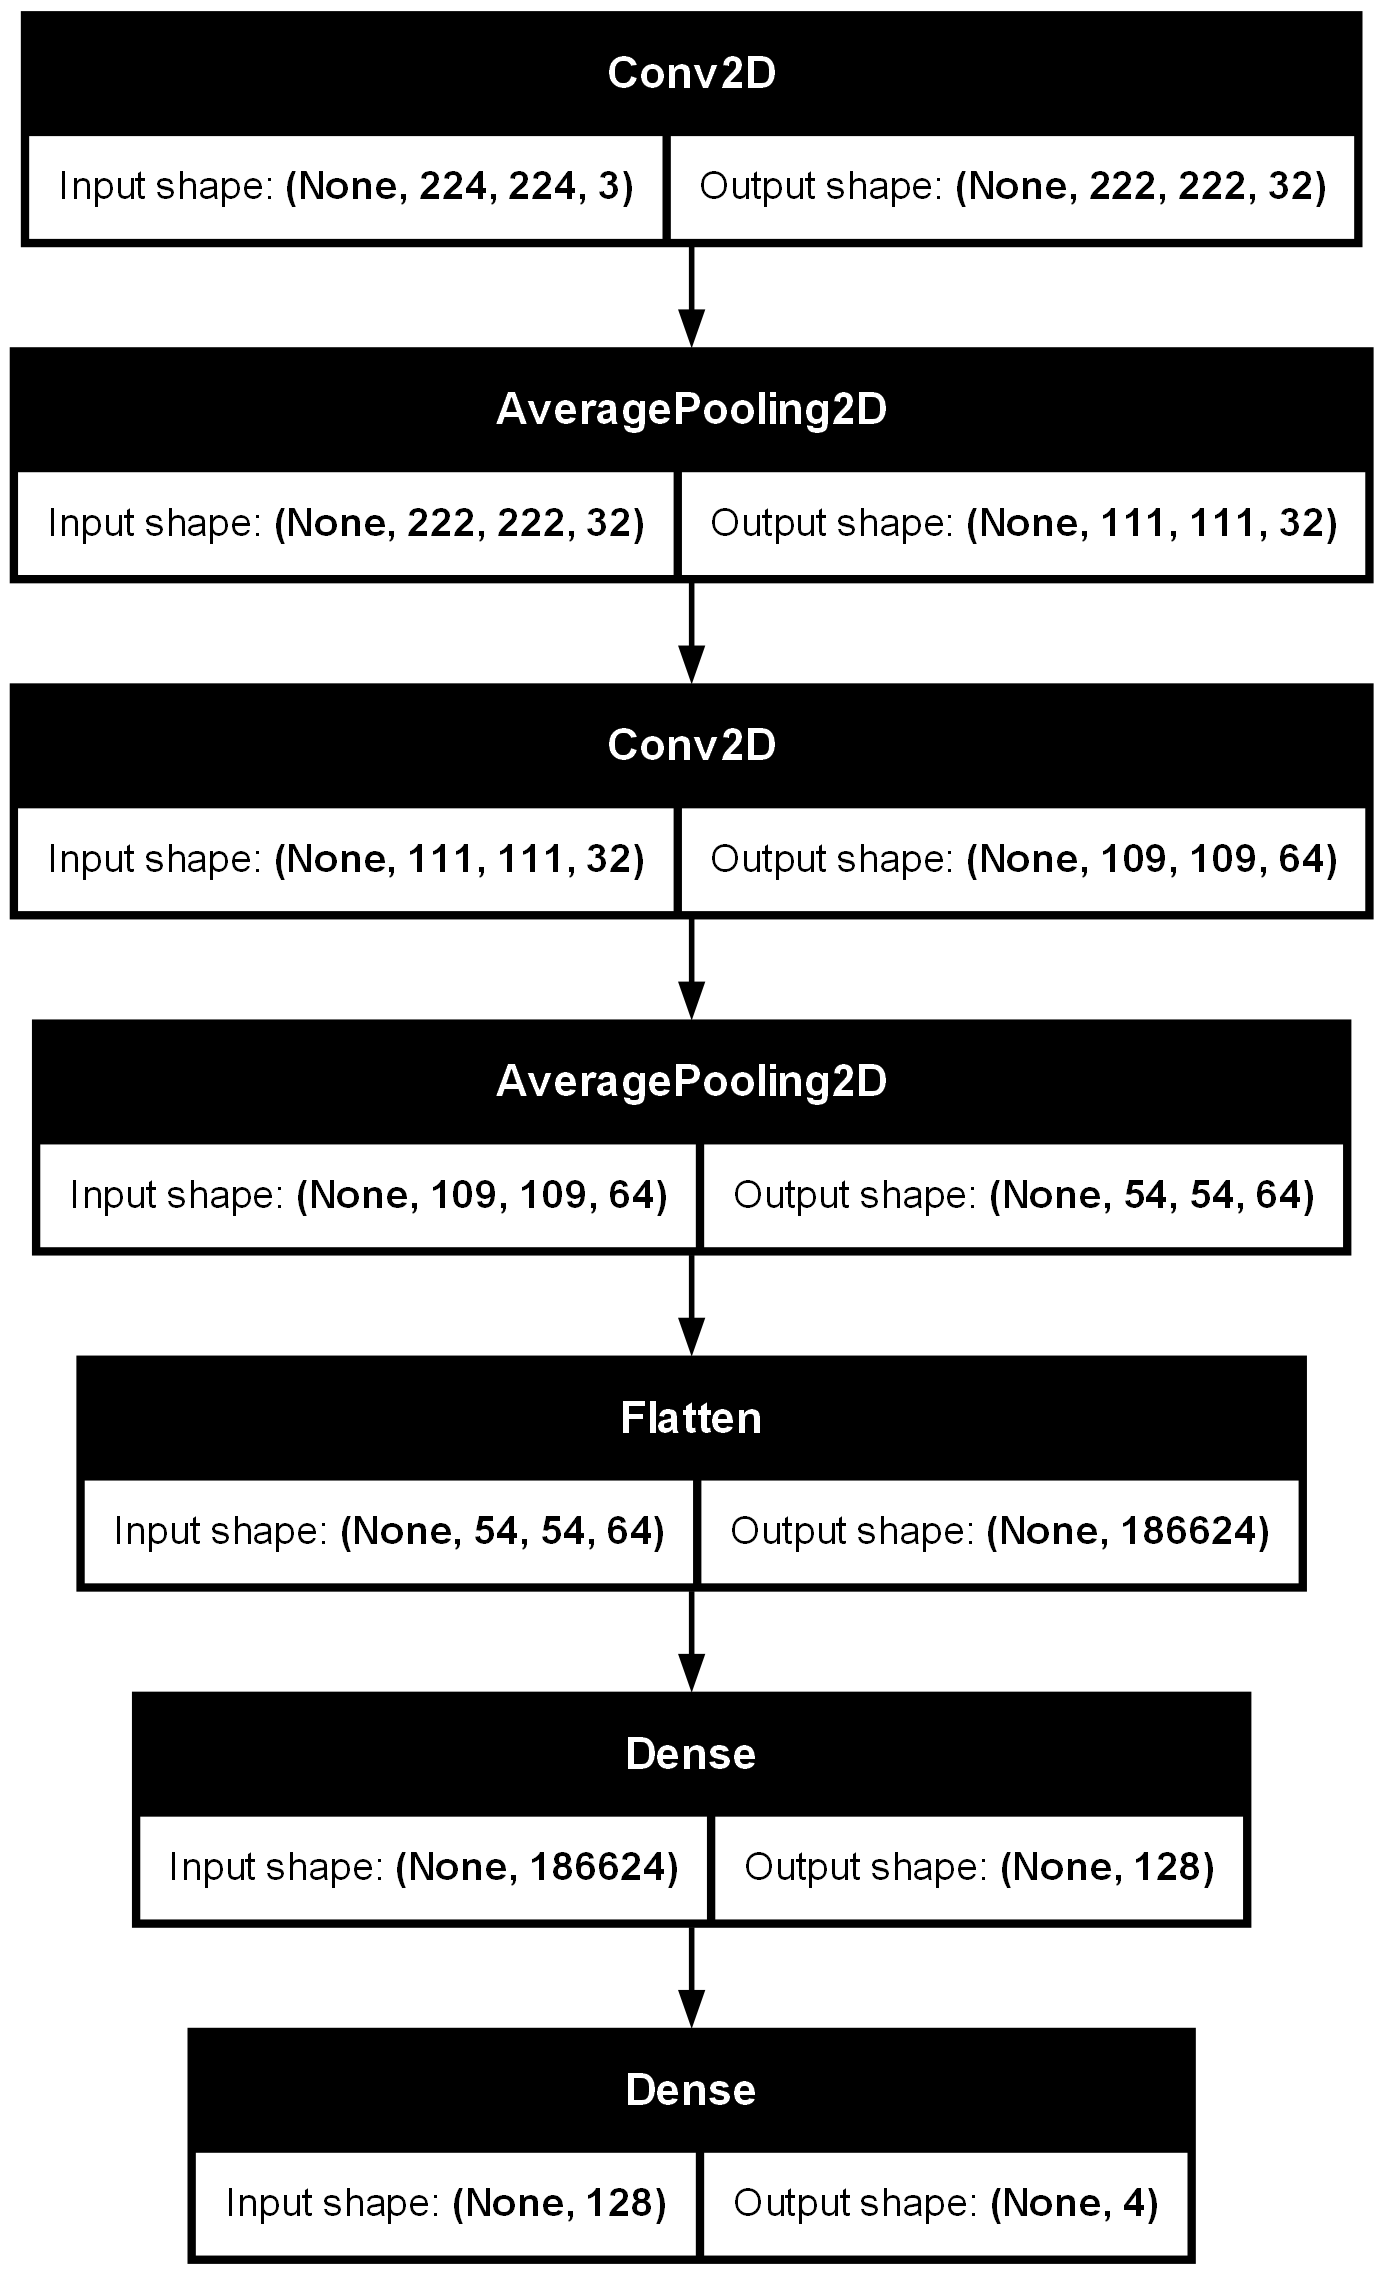

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.70      0.66      0.68        29
   Lung_Opacity       0.60      0.65      0.62        23
         Normal       0.71      0.73      0.72        30
Viral Pneumonia       0.91      0.88      0.89        24

       accuracy                           0.73       106
      macro avg       0.73      0.73      0.73       106
   weighted avg       0.73      0.73      0.73       106



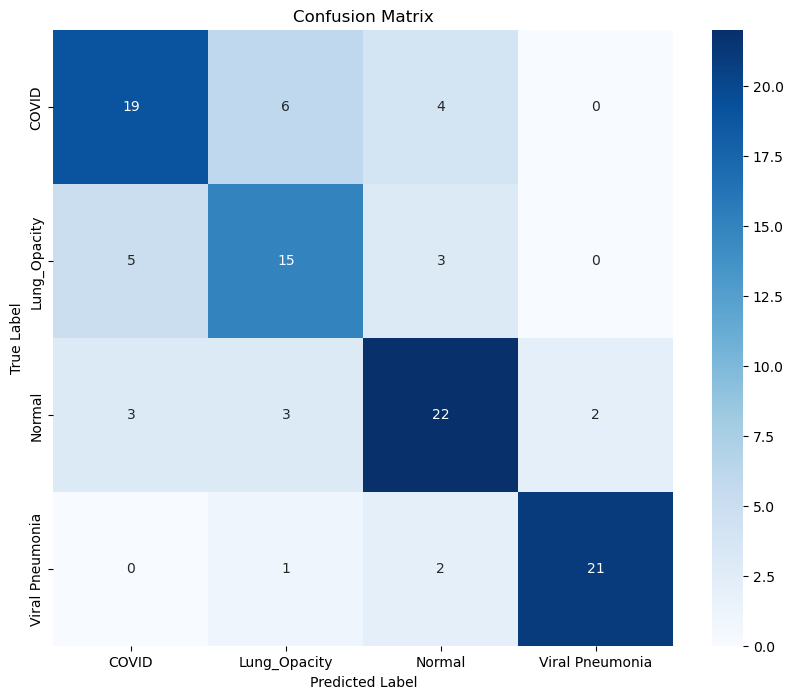

Image 1:
  COVID: 27.34%
  Lung_Opacity: 32.64%
  Normal: 35.70%
  Viral Pneumonia: 4.32%

Image 2:
  COVID: 54.06%
  Lung_Opacity: 13.96%
  Normal: 20.19%
  Viral Pneumonia: 11.79%

Image 3:
  COVID: 1.02%
  Lung_Opacity: 2.21%
  Normal: 9.46%
  Viral Pneumonia: 87.31%

Image 4:
  COVID: 40.72%
  Lung_Opacity: 32.30%
  Normal: 19.62%
  Viral Pneumonia: 7.37%

Image 5:
  COVID: 10.40%
  Lung_Opacity: 83.62%
  Normal: 5.66%
  Viral Pneumonia: 0.33%

Image 6:
  COVID: 61.18%
  Lung_Opacity: 25.40%
  Normal: 12.40%
  Viral Pneumonia: 1.03%

Image 7:
  COVID: 33.73%
  Lung_Opacity: 38.39%
  Normal: 18.35%
  Viral Pneumonia: 9.54%

Image 8:
  COVID: 67.73%
  Lung_Opacity: 21.17%
  Normal: 8.47%
  Viral Pneumonia: 2.63%

Image 9:
  COVID: 35.32%
  Lung_Opacity: 40.68%
  Normal: 22.89%
  Viral Pneumonia: 1.12%

Image 10:
  COVID: 62.99%
  Lung_Opacity: 24.98%
  Normal: 10.88%
  Viral Pneumonia: 1.15%

Image 11:
  COVID: 0.05%
  Lung_Opacity: 0.14%
  Normal: 99.43%
  Viral Pneumonia: 0.38%

Im

In [35]:
# Step 1: Make predictions on the test set
predictions = model.predict(test_gen)

# Step 2: Convert predictions to percentage format
predictions_percentage = predictions * 100  # Convert to percentage

# Step 3: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step 4: Get true labels from the test generator
true_classes = test_gen.classes

# Step 5: Generate a classification report
from sklearn.metrics import classification_report
class_report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())
print("Classification Report:\n", class_report)

# Step 6: Generate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 7: Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Display predictions in percentage format
for i in range(len(predictions)):
    print(f"Image {i+1}:")
    for j, class_name in enumerate(test_gen.class_indices.keys()):
        print(f"  {class_name}: {predictions_percentage[i][j]:.2f}%")
    print()

